## Studying Growth Instability

This code lets us explore how QLC-2 solutions vary with the following parameters:
- $D_{surf}$ (surface diffusion coefficient of the QLL)
- $\nu_{kin}$ (rate at which water vapor strikes the surface)
- $\sigma_r$ (reduction in supersaturation at facet centers relative to corners)
- $L$ (crystal dimension)
- $\tau_{eq}$, $\sigma_o$, $\overline N$, and $N^*$ (all atomistic-level characteristics of the ice surface)

These are specified as small departures from a baseline scenario, taken from *Parameter Baseline*, which tries to come up with a self-consistent set of parameters at given values of:
- $T$ (ambient temperature)
- $P$ (ambient air pressure)
- $\sigma_{I,far}$ and $x_{far}$ (super/subsaturation of water vapor far from the crystal, and distance from the crystal at which $\sigma_{I,far}$ is specified)

In [18]:
import numpy as np
import matplotlib.pylab as plt
from pint import UnitRegistry; AssignQuantity = UnitRegistry().Quantity
from importlib import reload
from scipy import optimize
from matplotlib import rcParams

import sys
sys.path.append('..')
import QLCstuff as QLC

In [19]:
%matplotlib inline
ticklabelsize = 15
linewidth = 1
fontsize = 15
color = 'k'
markersize = 10

# Preferred units
distance_unit = 'micrometer'
pressure_unit = 'pascal'
time_unit = 'microsecond'
temperature_unit = 'kelvin'

### These are parameters we're not planning on varying

In [20]:
# Properties of the QLL
Nbar = 1.0
Nstar = .9/(2*np.pi)
print('Nbar =', Nbar)
print('Nstar =', Nstar)

# The equilibration time
tau_eq = AssignQuantity(1,'microsecond')
print('tau_eq =',tau_eq)

# Difference in equilibrium supersaturation between microsurfaces I and II
sigma0 = 0.2
print('sigma0 =',sigma0)

# Thickness of a monolayer (have to decide which of these we want)
# nmpermonolayer = AssignQuantity(0.3,'nanometer')
nmpermonolayer = AssignQuantity(0.389,'nanometer') # Prismatic facet as used in Neshyba et al 2016
print('nmpermonolayer =', nmpermonolayer)

# Other baseline values
D_baseline = AssignQuantity(3.65e-04,'micrometer^2/microsecond'); print('D_baseline =',D_baseline)
nu_kin_baseline = AssignQuantity(105,'micrometer/second'); print('nu_kin_baseline =', nu_kin_baseline)
L_baseline = AssignQuantity(30,'micrometer'); print('L_baseline =', L_baseline)

Nbar = 1.0
Nstar = 0.1432394487827058
tau_eq = 1 microsecond
sigma0 = 0.2
nmpermonolayer = 0.389 nanometer
D_baseline = 0.000365 micrometer ** 2 / microsecond
nu_kin_baseline = 105 micrometer / second
L_baseline = 30 micrometer


### Parameters we might vary

In [21]:
# Defining scenarios
# sigmaI_corner_baseline = AssignQuantity(0.244,'dimensionless') 
sigmaI_corner_baseline = AssignQuantity(0.22,'dimensionless') 
c_r_percent_baseline = AssignQuantity(1.068,'dimensionless')
c_r_baseline = c_r_percent_baseline/100
tau_eq_baseline = AssignQuantity(1.0,'microsecond')
odemethod = 'RK23' # Explicit Runge-Kutta  
odemethod = 'DOP853' # Explicit Runge-Kutta (order 8)
odemethod = 'LSODA' # Adams/BDF method 
odemethod = 'Radau' # Implicit Runge-Kutta of the Radau IIA family of order 5 (takes ~200x explicit methods)
odemethod = 'RK45' # Explicit Runge-Kutta
odemethod = 'BDF' # Implicit multi-step variable-order (1 to 5) method (takes ~100x explicit methods)

In [22]:
parameter_names = ['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']; print(parameter_names)
result_names = ['g_ice_QLC', 'lambda_average', 'alpha']; print(result_names)

['L', 'D', 'nu_kin', 'sigmaI_corner', 'c_r(%)']
['g_ice_QLC', 'lambda_average', 'alpha']


### Make a list of parameter sets

In [23]:
parameterlist_mag = []

# Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      0.215, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

parameterlist_mag.append(
    [L_baseline.magnitude, D_baseline.magnitude, 105, 
     0.21, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Varying the diffusion coefficient
# parameterlist_mag.append(
#     [L_baseline.magnitude, 0.0002, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Varying the freezing time constant
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude,  
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, 1.1])

# # Varying the kinetic velocity 
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, 110, 
#      sigmaI_corner_baseline, c_r_percent_baseline.magnitude, tau_eq_baseline.magnitude])

# # Baseline
# parameterlist_mag.append(
#     [L_baseline.magnitude, D_baseline.magnitude, nu_kin_baseline.magnitude, 
#      sigmaI_corner_baseline, 1.0, tau_eq_baseline.magnitude])

print(parameterlist_mag)

[[30, 0.000365, 105, 0.21, 1.068, 1.0]]


### Run the list

L = 30 micrometer
D =  0.000365 micrometer ** 2 / microsecond
nu_kin =  105 micrometer / second
nu_kin_mlyperus = 0.26992287917737784 / microsecond
sigmaI_corner = 0.21 dimensionless
c_r_percent = 1.068 dimensionless
nx (crystal) = 801
Spacing of points on the ice surface = 0.07499999999999929 micrometer
Estimating times for the trajectory run
   time (est) =  47.781848256749655 millisecond
   time (used) =  20 millisecond
   dt = 40.08016032064128 microsecond
10 % elapsed time is 15.230 minutes
20 % elapsed time is 31.588 minutes
30 % elapsed time is 35.034 minutes
40 % elapsed time is 38.219 minutes
50 % elapsed time is 41.354 minutes
60 % elapsed time is 44.671 minutes
70 % elapsed time is 47.859 minutes
80 % elapsed time is 51.059 minutes
90 % elapsed time is 54.234 minutes
100% done
status =  0
message =  The solver successfully reached the end of the integration interval.
['message', 'nfev', 'njev', 'nlu', 'sol', 'status', 'success', 't', 't_events', 'y', 'y_events']
c_r(%) = 1.0

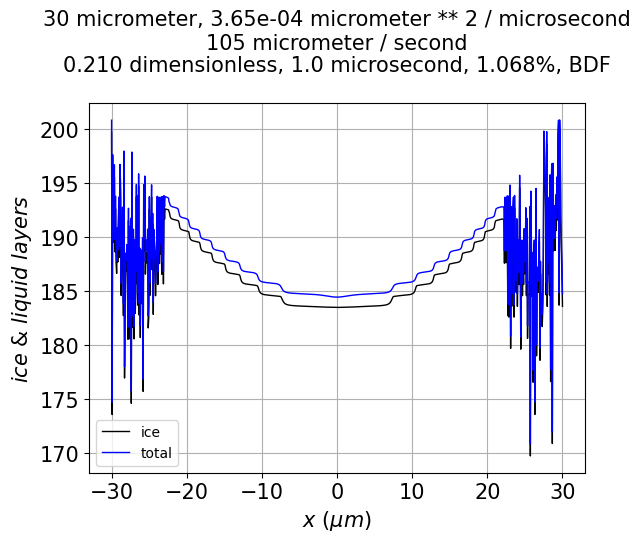

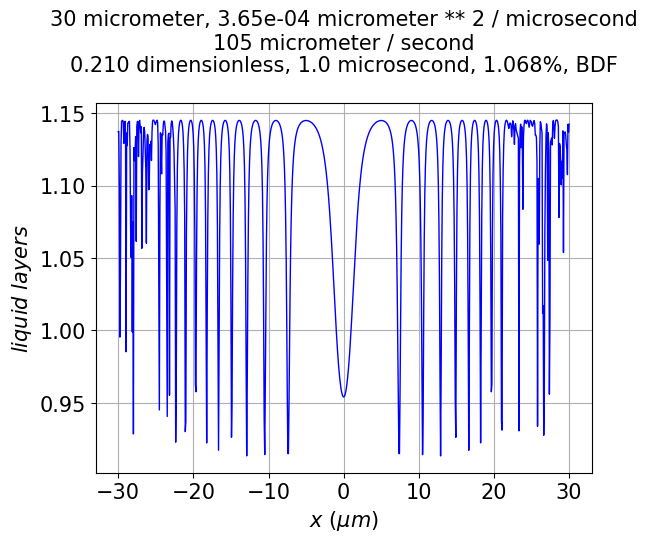

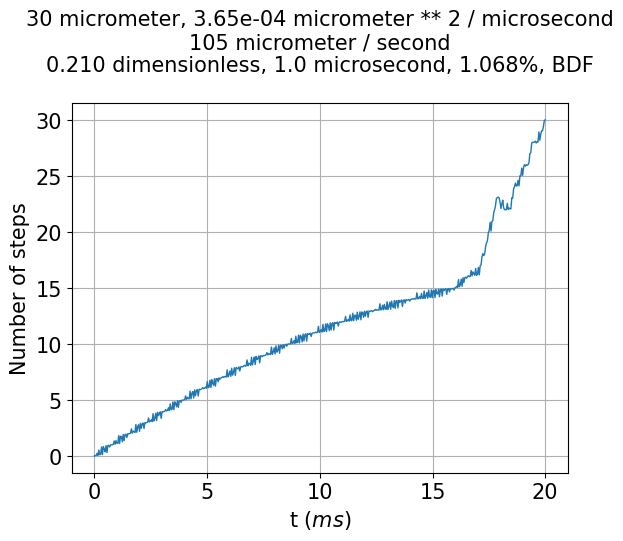

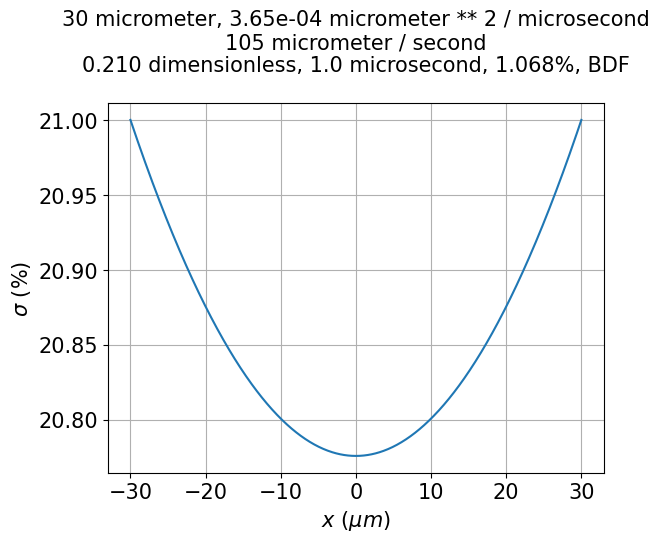

In [24]:
parameterlist = []
resultslist = []
for parameter_magnitudes in parameterlist_mag:

    # Size of the box
    L = AssignQuantity(parameter_magnitudes[0],'micrometer') 
    print('L =', L)

    # Surface diffusion coefficient
    D = AssignQuantity(parameter_magnitudes[1],'micrometer^2/microsecond') 
    print('D = ',D)

    # Kinetic velocity
    nu_kin = AssignQuantity(parameter_magnitudes[2],'micrometer / second')
    print('nu_kin = ',nu_kin)
    nu_kin_mlyperus = nu_kin/nmpermonolayer
    nu_kin_mlyperus.ito('1/microsecond')
    print('nu_kin_mlyperus =', nu_kin_mlyperus)

    # Supersaturation at the corner
    sigmaI_corner = AssignQuantity(parameter_magnitudes[3],'dimensionless')
    print('sigmaI_corner =', sigmaI_corner)
    
    # Supersaturation at the corner
    c_r_percent = AssignQuantity(parameter_magnitudes[4],'dimensionless')
    print('c_r_percent =', c_r_percent)
    c_r = c_r_percent/100

    # Freezing time constant
    tau_eq = AssignQuantity(parameter_magnitudes[5],'microsecond')

    # Number of points on the ice surface
    Lx_reference = AssignQuantity(75,'micrometer')
    nx_crystal = int(6000*L/Lx_reference) # Resolution with explicit integration methods
    nx_crystal = int(2000*L/Lx_reference) # Reduced resolution for implicit methods
#     nx_crystal = int(1000*L/Lx_reference) # Reduced resolution for implicit methods
    if (nx_crystal % 2 == 0): nx_crystal += 1
    print('nx (crystal) =', nx_crystal)
    x_QLC = np.linspace(-L,L,nx_crystal)
    
    # supersaturation over the ice surface
    sigmaI_QLC = sigmaI_corner*(c_r*(x_QLC/L)**2+1-c_r)

    # Scaled version of the diffusion coefficient
    deltax = x_QLC[1]-x_QLC[0]
    print('Spacing of points on the ice surface =', deltax)
    Doverdeltax2 = D/deltax**2

    # Estimating/deciding on how long to make the integration
    print('Estimating times for the trajectory run')
    L_reference = AssignQuantity(1,'millimeter')
    time_reference = AssignQuantity(1,'millisecond')
    tlast_estimated = (L*L_reference/D*time_reference)**.5 / 6
    tlast_estimated.ito('millisecond'); print('   time (est) = ', tlast_estimated)
    tlast = tlast_estimated # Use this line to keep the estimated time
    tlast = AssignQuantity(20,'millisecond') # Use this line to override the estimated time
    print('   time (used) = ',tlast.to('msec'))
    tlast.ito('microsecond')

    # Number of time steps to report back
    ntimes = 500
    tkeep_1Darr = np.linspace(0,tlast,ntimes)
    print('   dt =', tkeep_1Darr[1]-tkeep_1Darr[0])

    # Initialize as a pre-equilibrated layer of liquid over ice
    Ntot_init_1D = np.ones(nx_crystal)
    NQLL_init_1D = QLC.getNQLL(Ntot_init_1D,Nstar,Nbar)

    title_params = \
        "{:.0f}".format(L.magnitude)+' '+str(L.units)+\
        ", "+np.format_float_scientific(D.magnitude,precision=2)+" "+str(D.units)+\
        "\n"+\
        "{:.0f}".format(nu_kin.magnitude)+' '+str(nu_kin.units)+\
        "\n"+\
        "{:.3f}".format(sigmaI_corner.magnitude)+' '+str(sigmaI_corner.units)+\
        ", "+"{:.1f}".format(tau_eq.magnitude)+' '+str(tau_eq.units)+\
        ", "+"{:.3f}".format(c_r_percent.magnitude)+'%'+\
        ", "+odemethod+\
        "\n"
#     print(title_params)

    # Solve the 1-D problem
    Ntotkeep_1D, NQLLkeep_1D = QLC.run_f1d(\
                    NQLL_init_1D, Ntot_init_1D, tkeep_1Darr,\
                    Nbar, Nstar, sigma0, nu_kin_mlyperus, Doverdeltax2, tau_eq, sigmaI_QLC,
                    AssignQuantity,\
                    verbose=0, odemethod=odemethod, max_step=0.02)
    Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D

    # Report
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,title_params=title_params)
    print('c_r(%) =', c_r_percent)
    print('final g_ice_QLC =',g_ice_QLC)
    alpha = g_ice_QLC/(sigmaI_corner*nu_kin)
    alpha = AssignQuantity(alpha,'dimensionless')
    print('alpha relative to sigmaI_corner =',alpha)

    plt.figure()
    plt.plot(x_QLC,sigmaI_QLC*100)
    plt.grid(True)
    plt.xlabel('$x \ (\mu m)$',fontsize=fontsize)
    plt.ylabel('$\sigma \ (\%)$',fontsize=fontsize)
    rcParams['xtick.labelsize'] = ticklabelsize 
    rcParams['ytick.labelsize'] = ticklabelsize
    plt.title(title_params,fontsize=fontsize)

    lastfraction = 0.3
    itimes_almost_end = int(ntimes*(1-lastfraction))
    f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
    nsteps_ss = np.mean(f[itimes_almost_end:-1])
    print('nsteps average of last', lastfraction*100, '% (', ntimes-itimes_almost_end, 'points) =', nsteps_ss)
    lambda_average = L/nsteps_ss
    print('estimated lambda =', lambda_average)
    results = [g_ice_QLC, lambda_average, alpha]
    resultslist.append(results)
    parameters = [L,D,nu_kin,sigmaI_corner,c_r_percent,tau_eq]
    parameterlist.append(parameters)
    print('Done with scenario ', len(resultslist),' out of ', len(parameterlist_mag))
    print('--------------------')

In [25]:
# Repackaging the parameters
L_list = np.empty(0)
D_list = np.empty(0)
nu_kin_list = np.empty(0)
sigmaI_corner_list = np.empty(0)
c_r_percent_list = np.empty(0)
tau_eq_list = np.empty(0)
for this_parameterset in parameterlist:
    L_list = np.append(L_list,this_parameterset[0])
    D_list = np.append(D_list,this_parameterset[1])
    nu_kin_list = np.append(nu_kin_list,this_parameterset[2])
    sigmaI_corner_list = np.append(sigmaI_corner_list,this_parameterset[3])
    c_r_percent_list = np.append(c_r_percent_list,this_parameterset[4])
    tau_eq_list = np.append(tau_eq_list,this_parameterset[5])
c_r_list = c_r_percent_list/100
print('parameters')
print(L_list)
print(D_list)
print(nu_kin_list)
print(sigmaI_corner_list)
print(c_r_percent_list)
print(tau_eq_list)

zp_list = np.abs((D_list/c_r_list/nu_kin_list))**.5
zp_list.ito('micrometer^.5')

# Repackaging the results
g_ice_QLC_list = np.empty(0)
lambda_average_list = np.empty(0)
alpha_list = np.empty(0)
for this_resultset in resultslist:
    g_ice_QLC_list = np.append(g_ice_QLC_list,this_resultset[0])
    lambda_average_list = np.append(lambda_average_list,this_resultset[1])
    alpha_list = np.append(alpha_list,this_resultset[2])
print('\n results \n')
print('g_ice_QLC_list =',g_ice_QLC_list,'\n')
print('lambda_average_list =',lambda_average_list,'\n')
print('alpha_list =',alpha_list,'\n')
print('zp_list =',zp_list,'\n')

parameters
[30.0] micrometer
[0.000365] micrometer ** 2 / microsecond
[105.0] micrometer / second
[0.21] dimensionless
[1.068] dimensionless
[1.0] microsecond

 results 

g_ice_QLC_list = [3.7203520334087674] micrometer / second 

lambda_average_list = [1.560203431776199] micrometer 

alpha_list = [0.168723448227155] dimensionless 

zp_list = [18.041230546814234] micrometer ** 0.5 



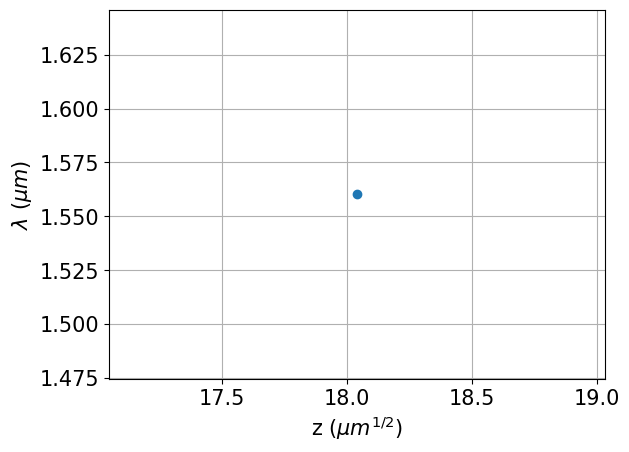

In [26]:
# Getting lambda as a function of the z-parameter
plt.figure()
plt.plot(zp_list,lambda_average_list,'o')
plt.xlabel('z ($\mu m ^{1/2}$)',fontsize=fontsize)
plt.ylabel('$\lambda \ (\mu m)$',fontsize=fontsize)
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.grid(True)

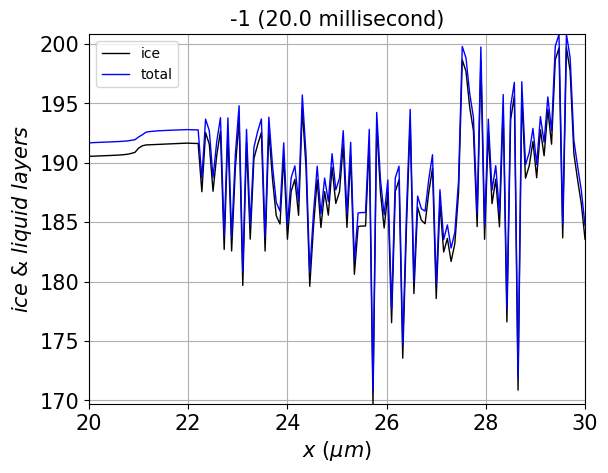

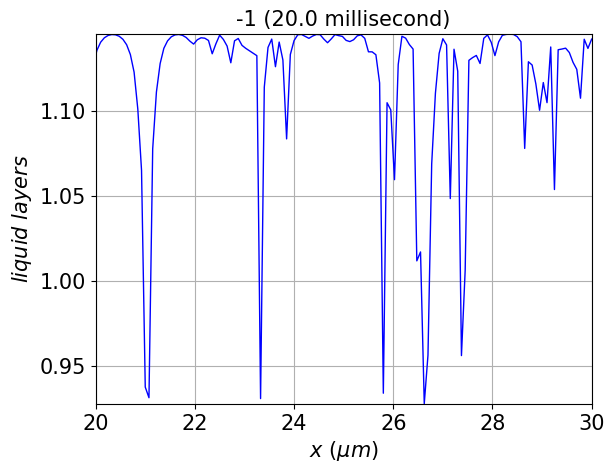

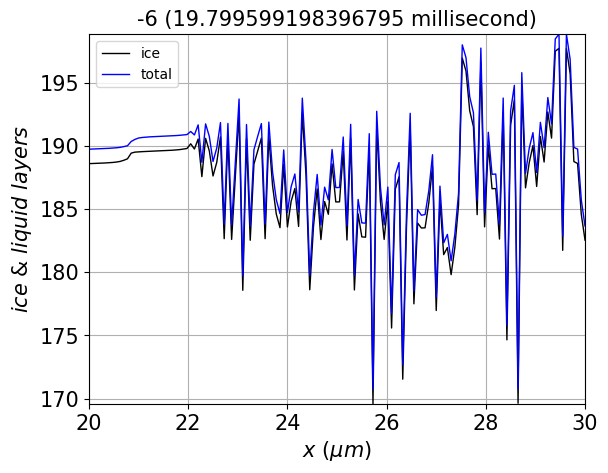

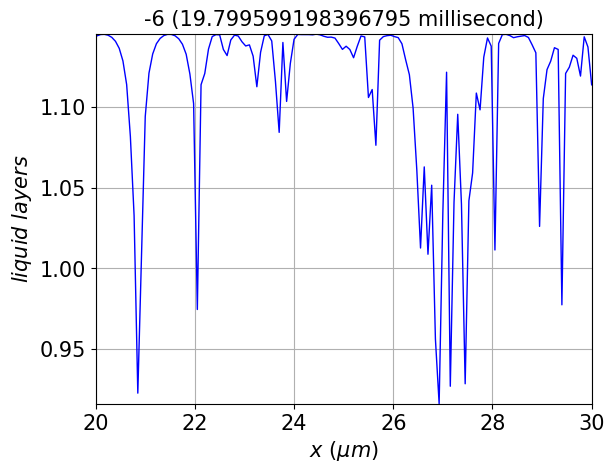

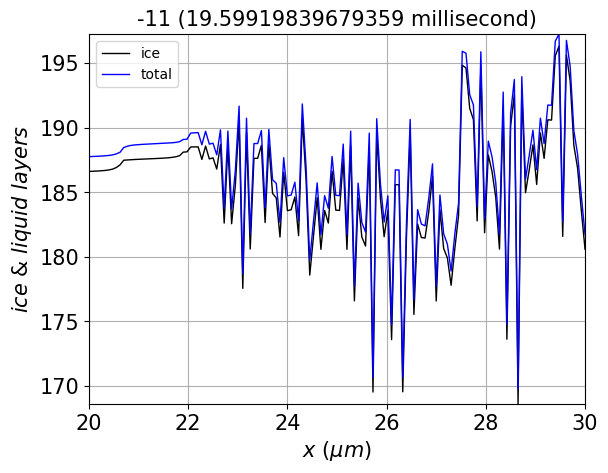

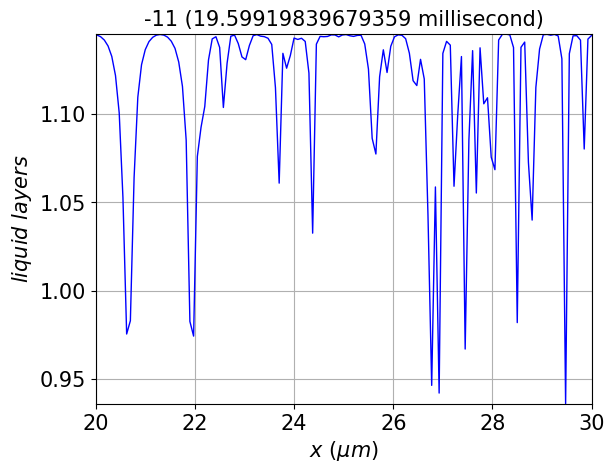

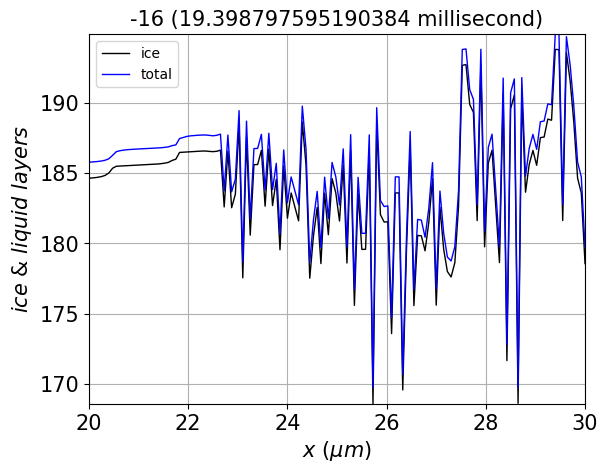

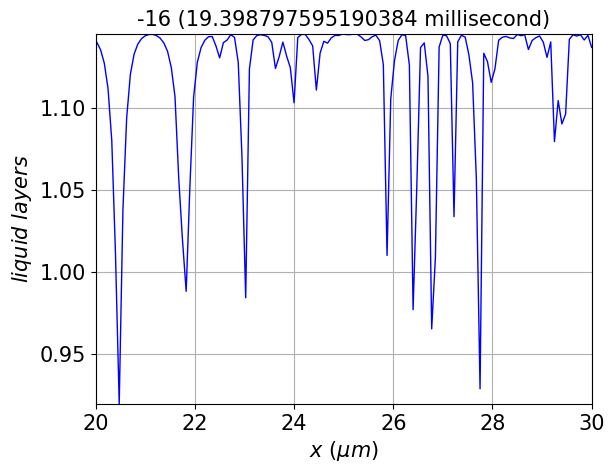

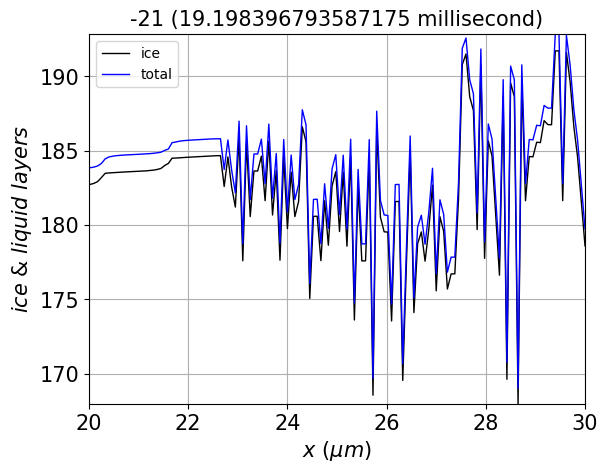

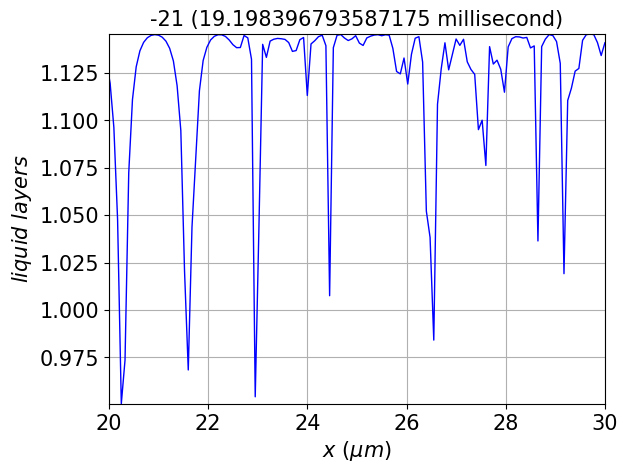

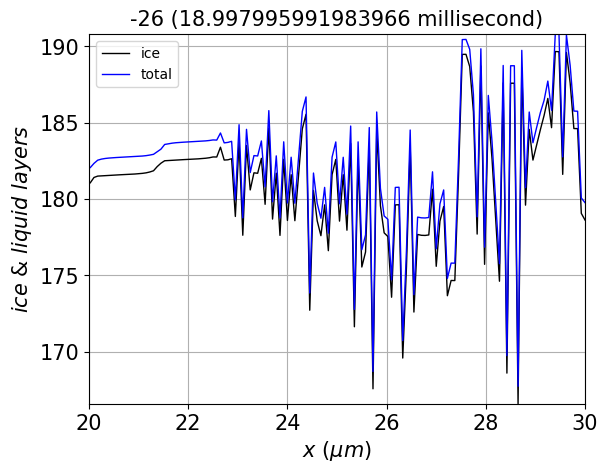

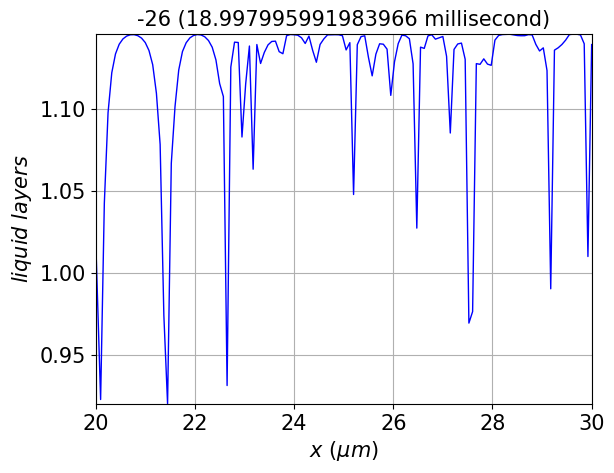

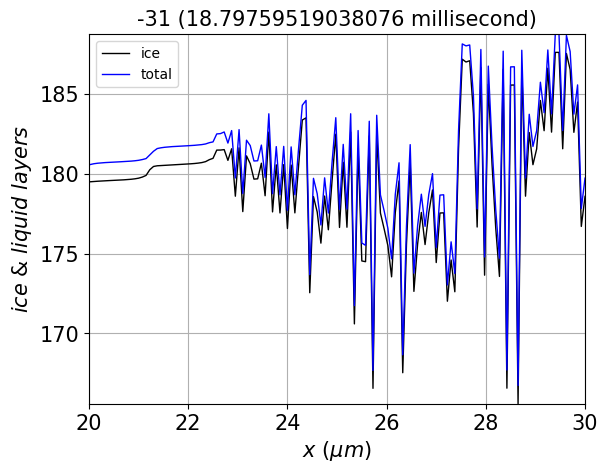

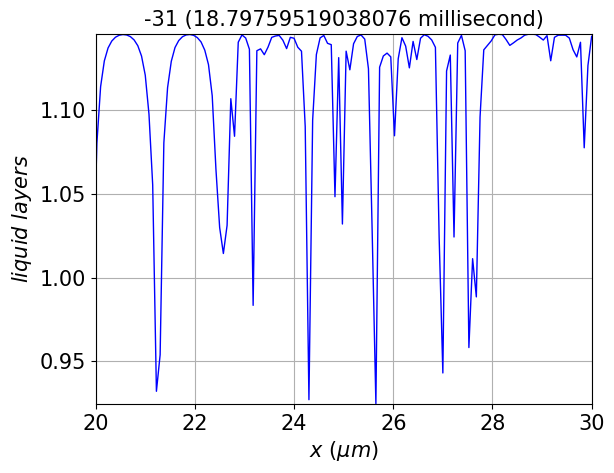

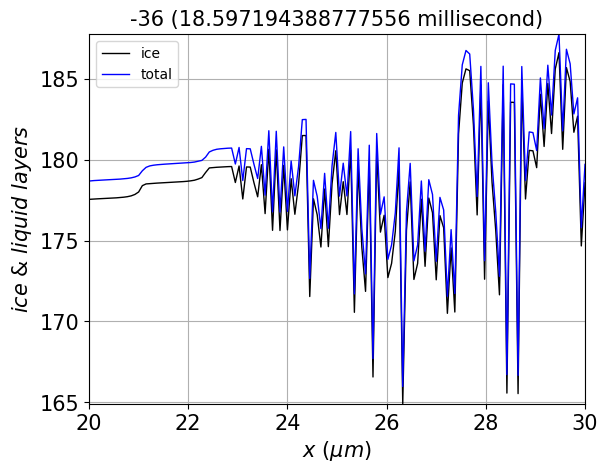

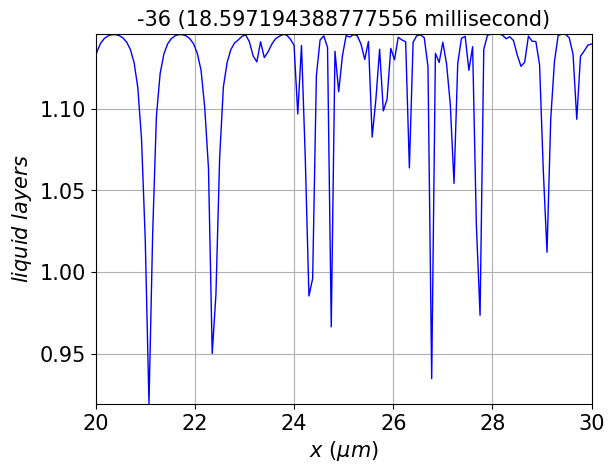

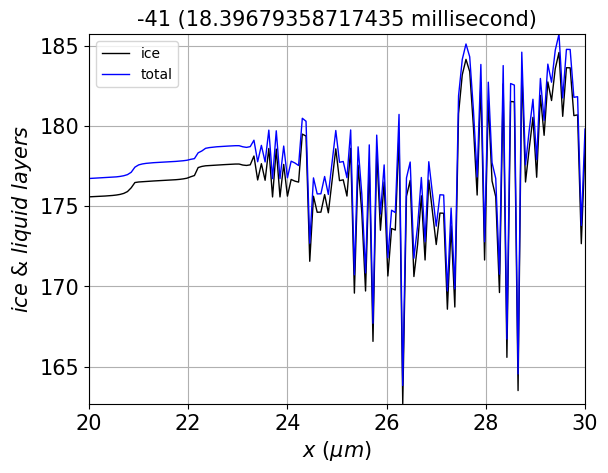

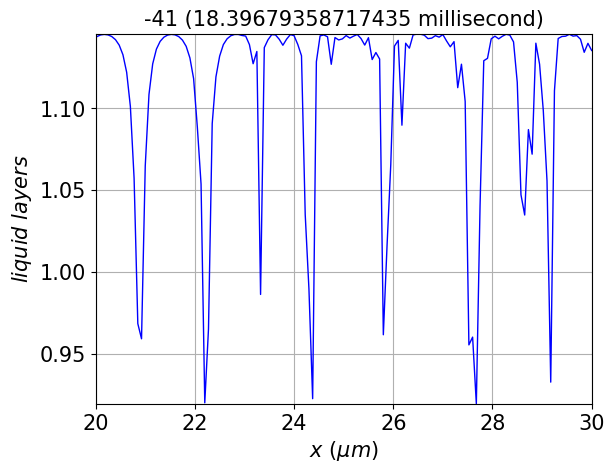

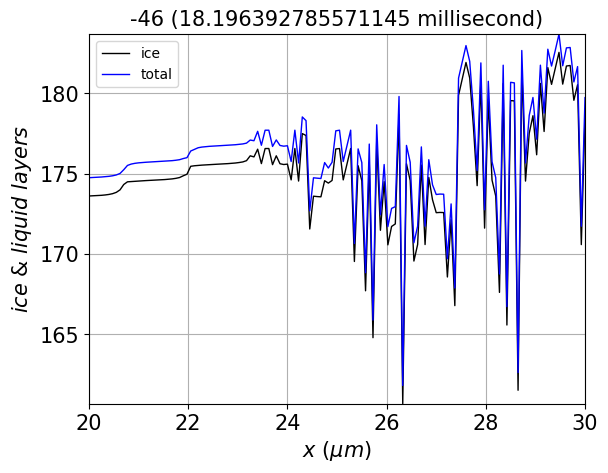

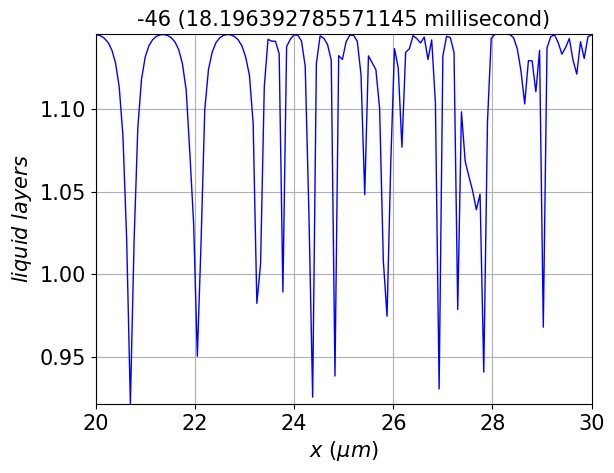

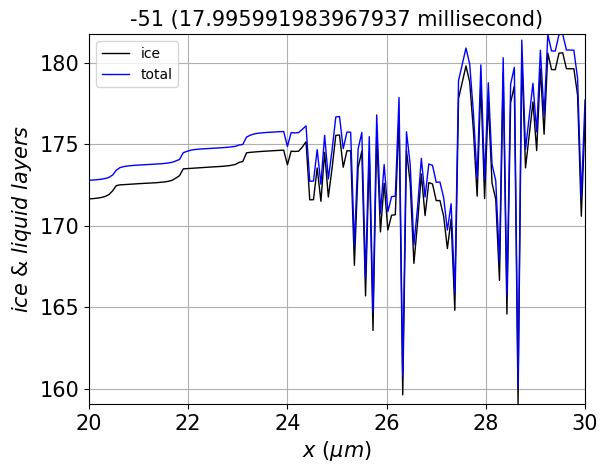

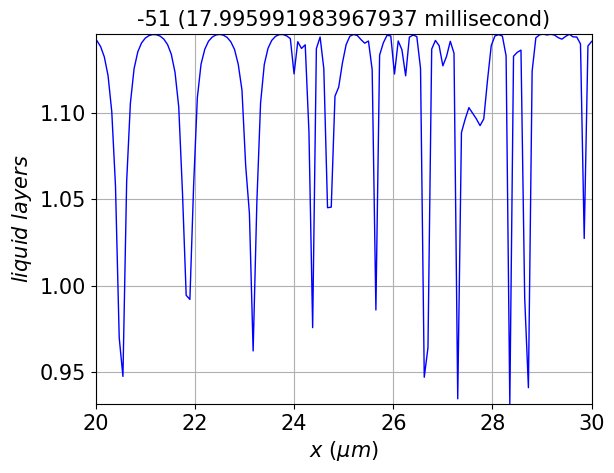

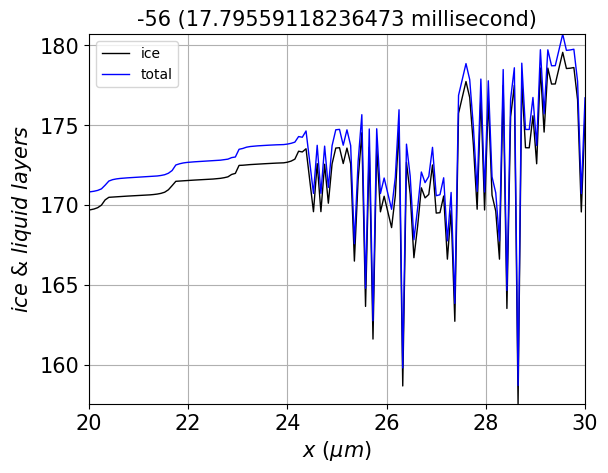

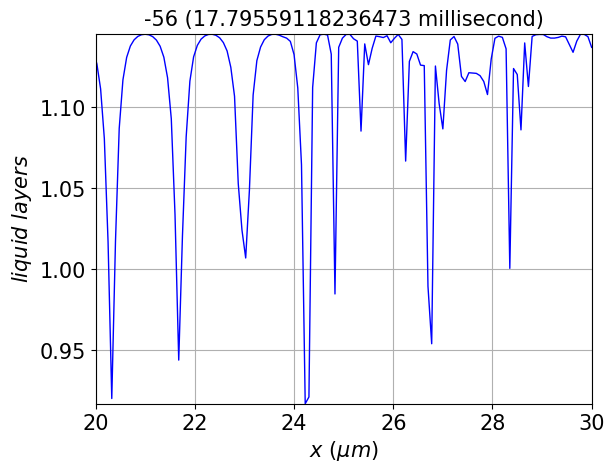

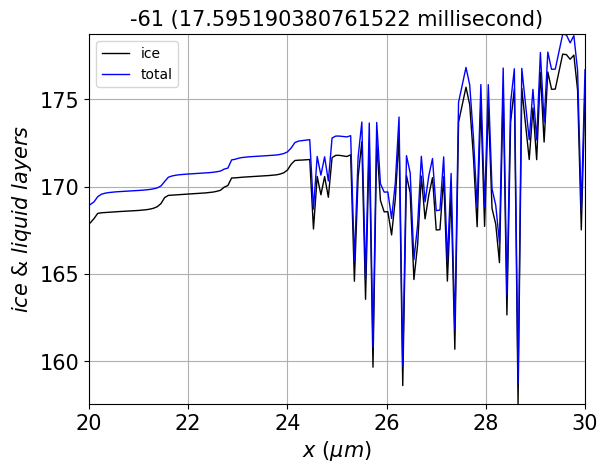

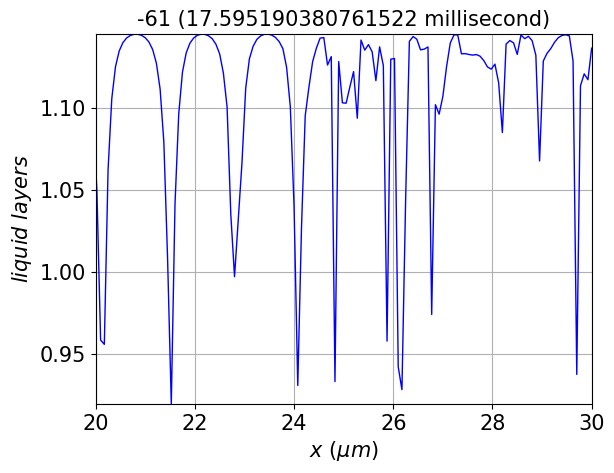

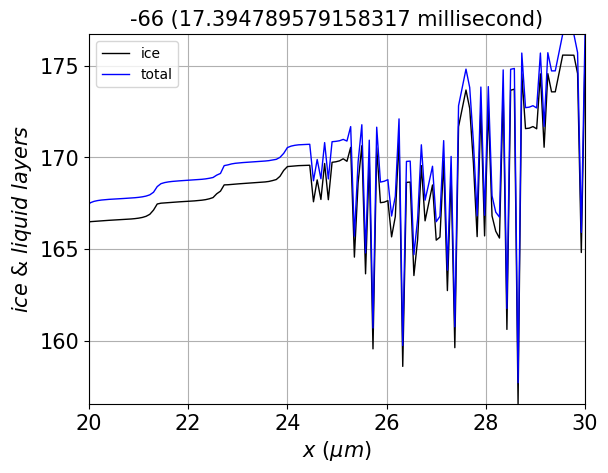

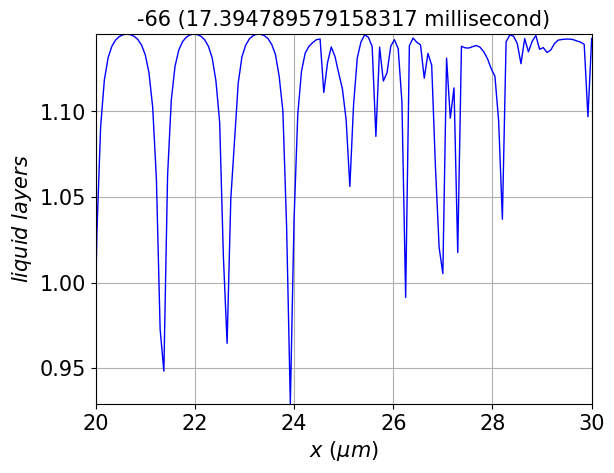

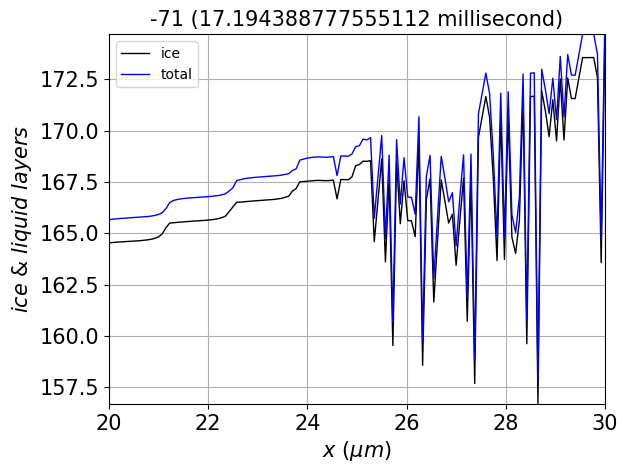

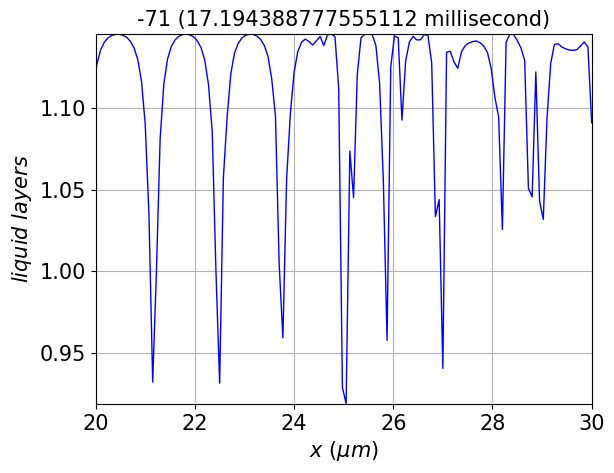

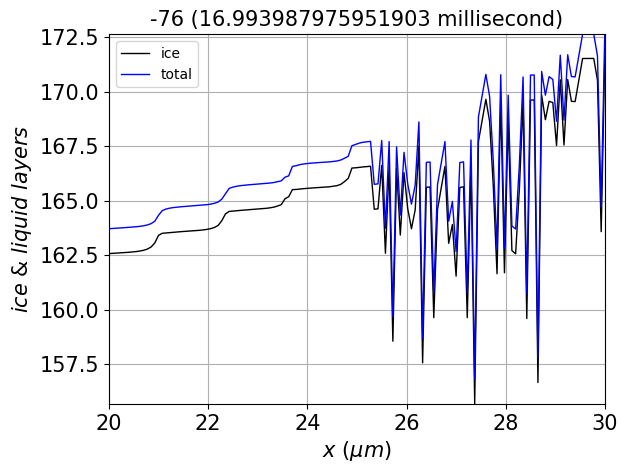

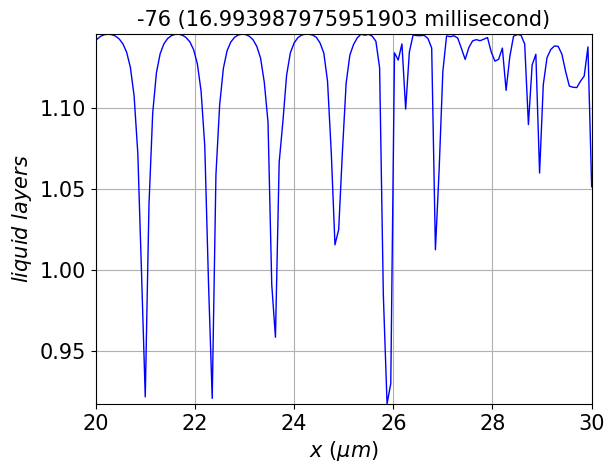

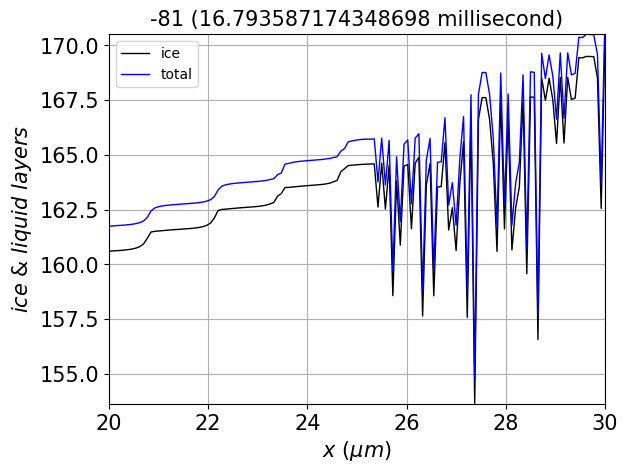

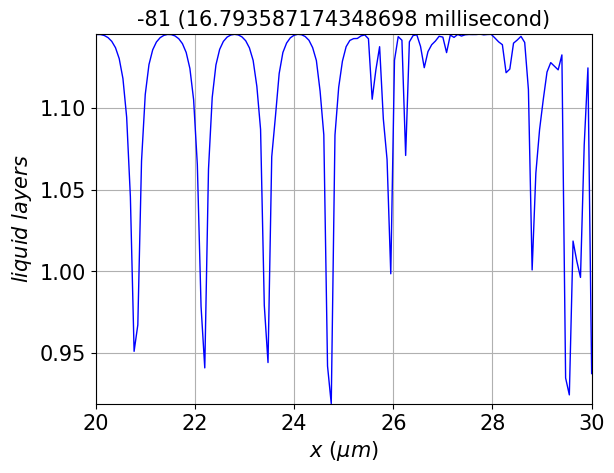

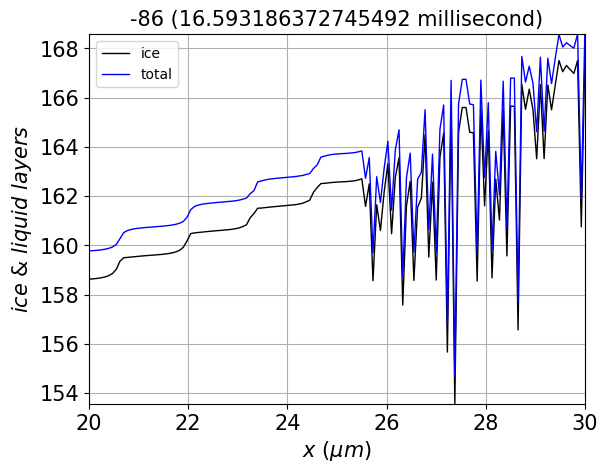

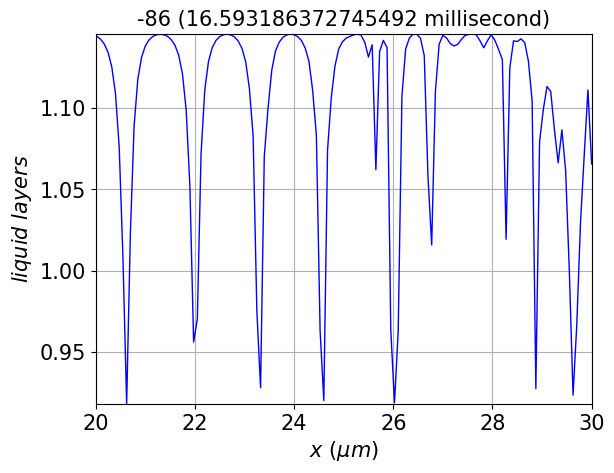

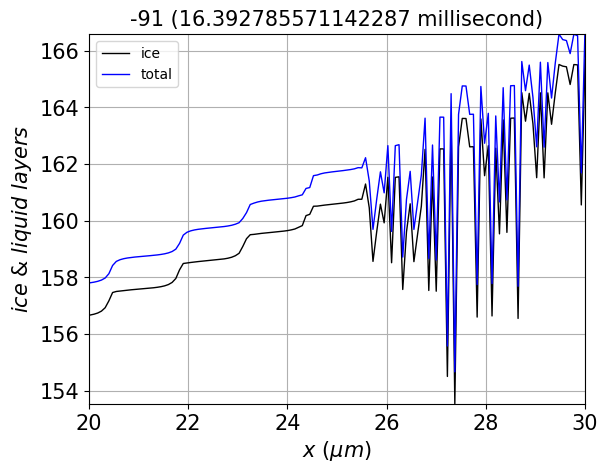

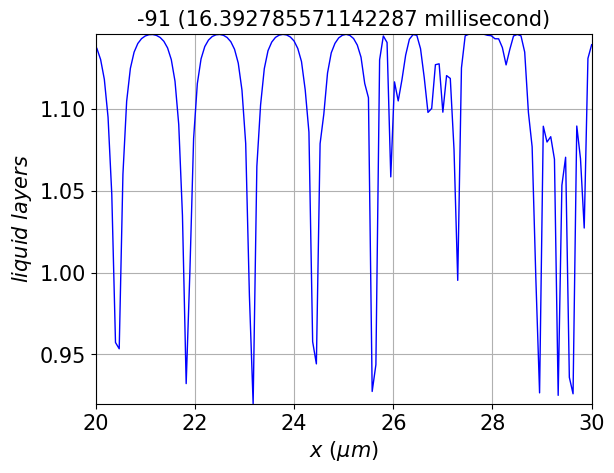

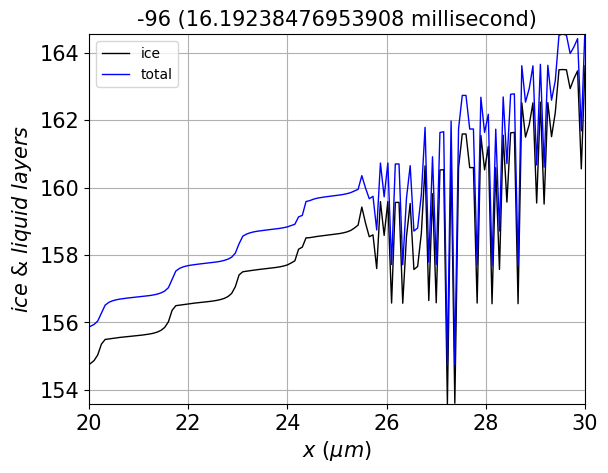

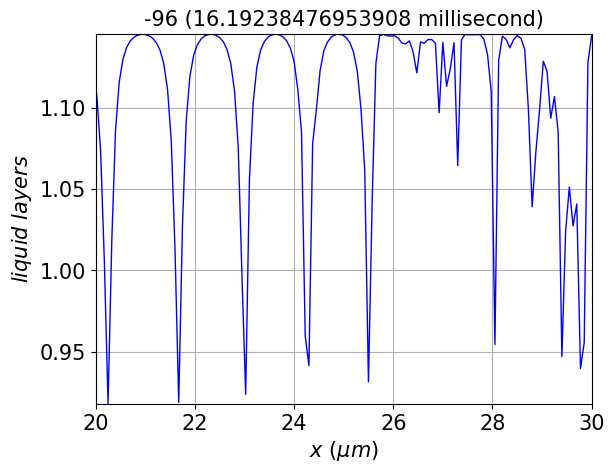

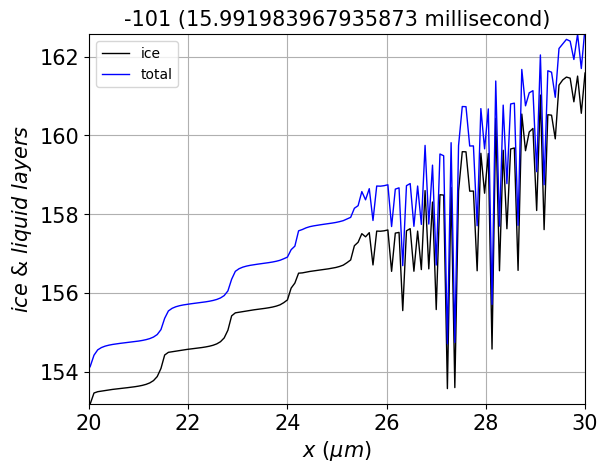

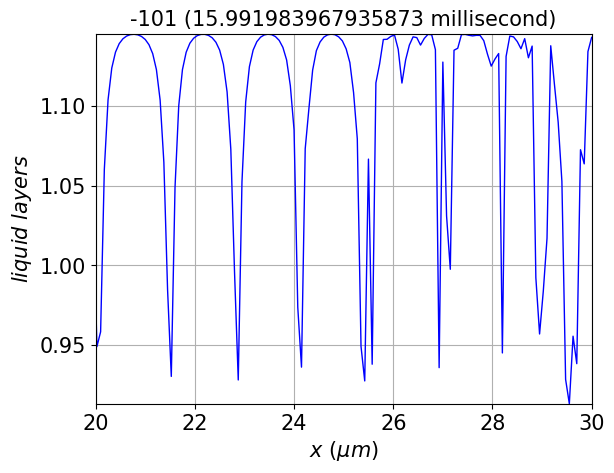

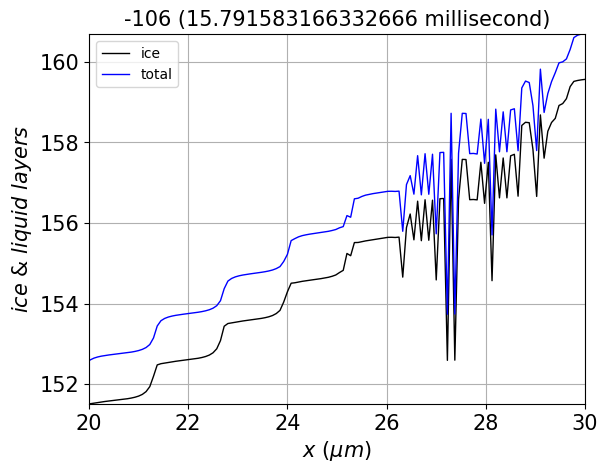

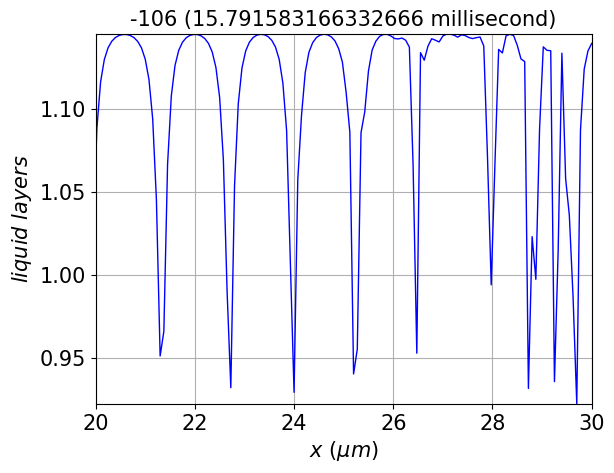

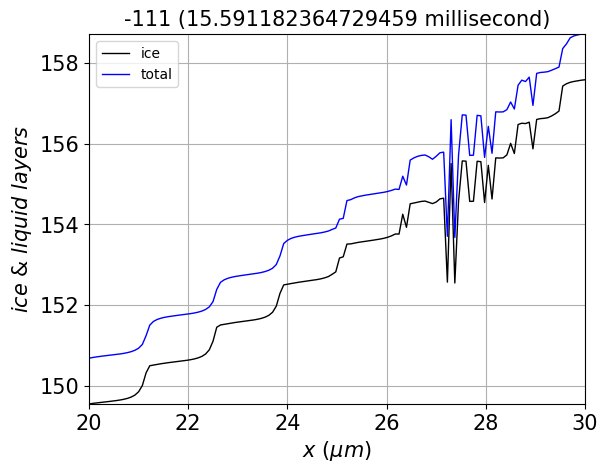

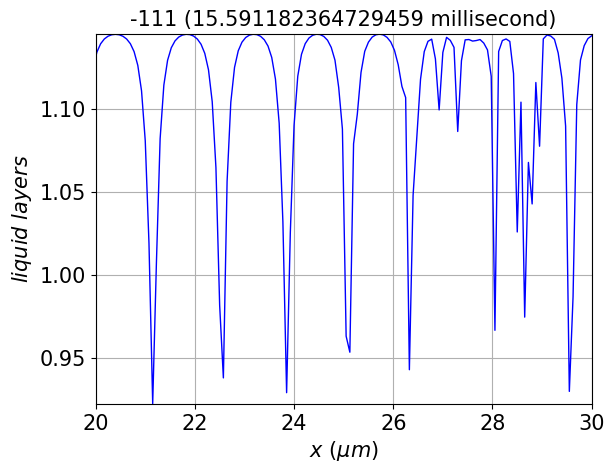

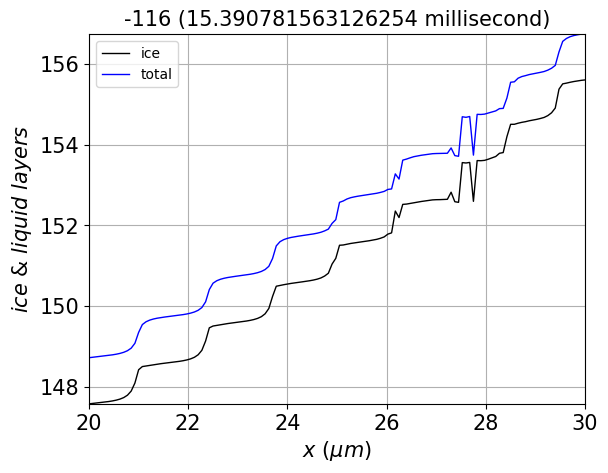

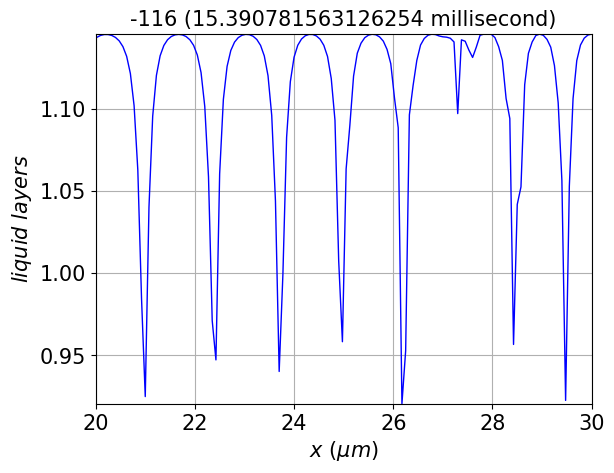

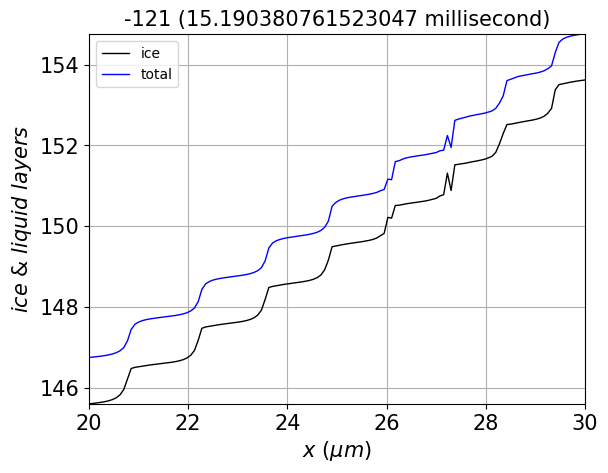

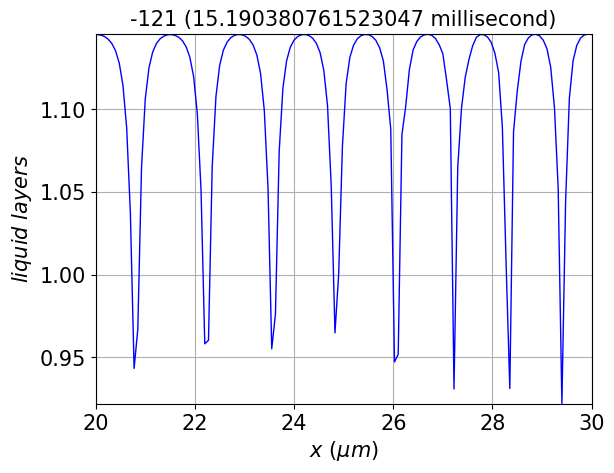

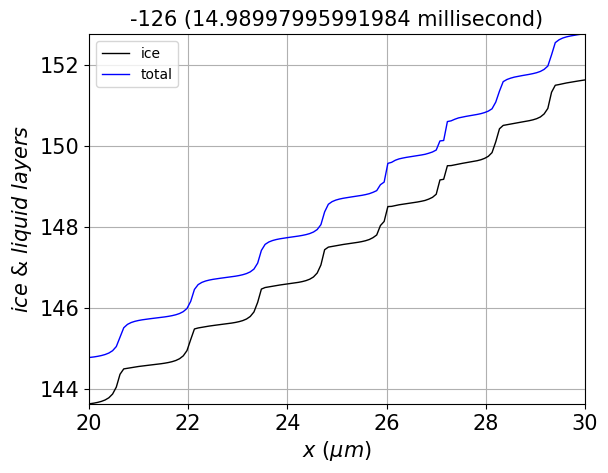

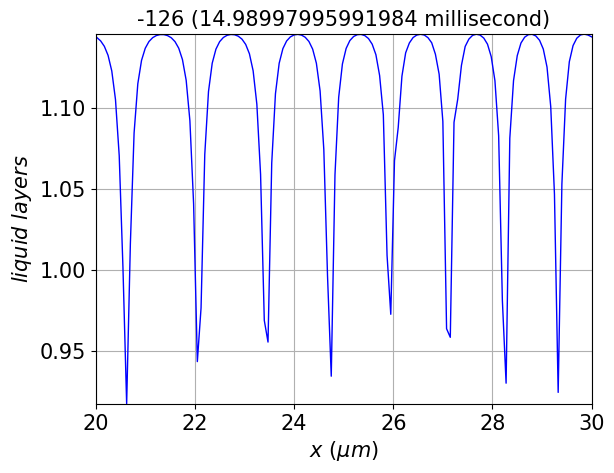

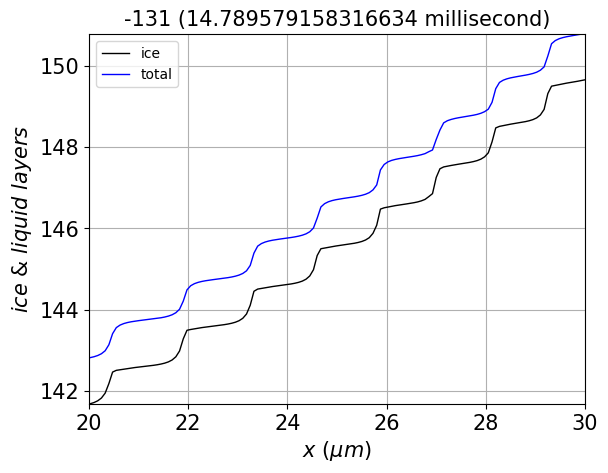

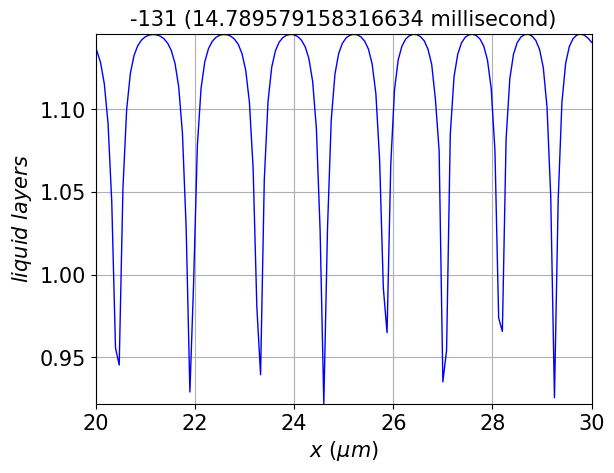

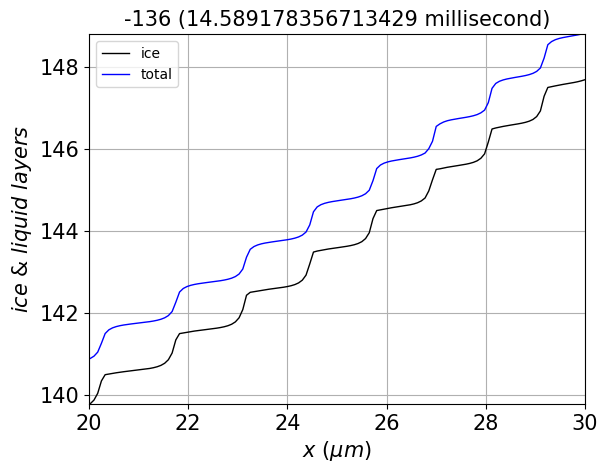

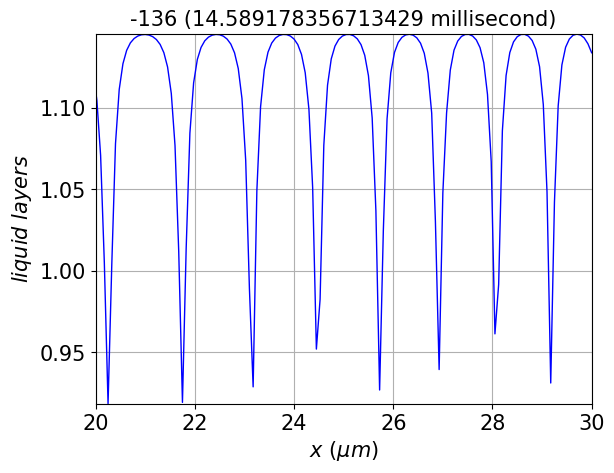

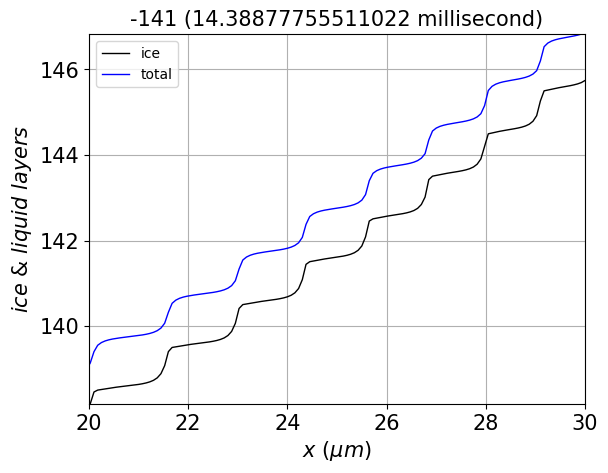

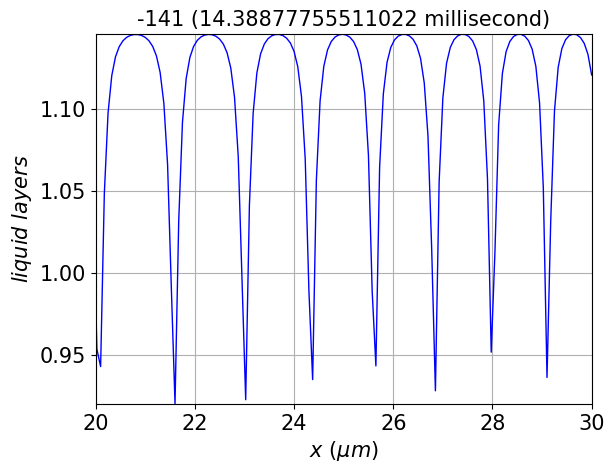

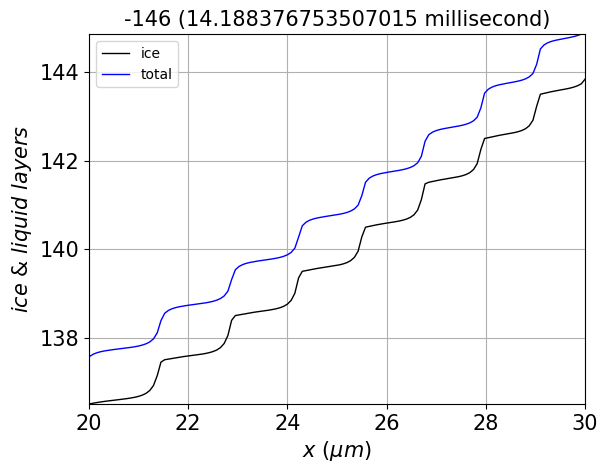

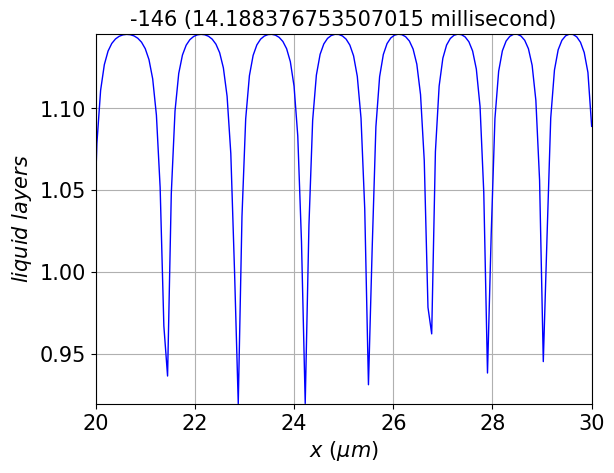

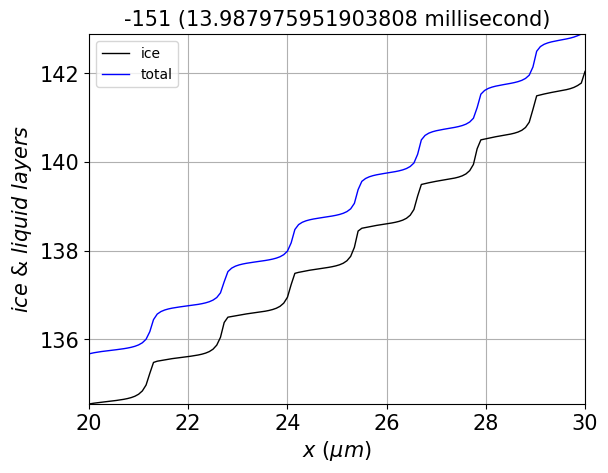

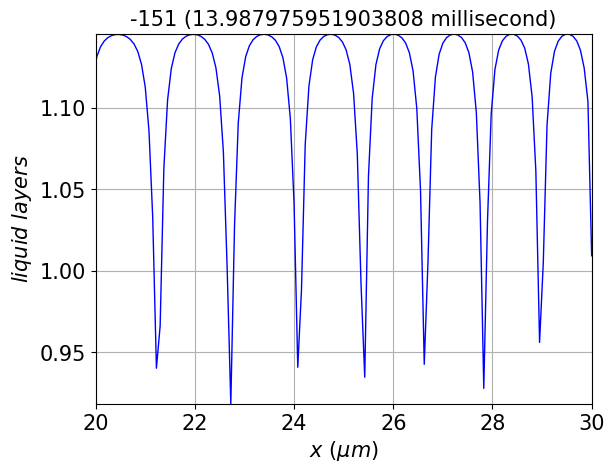

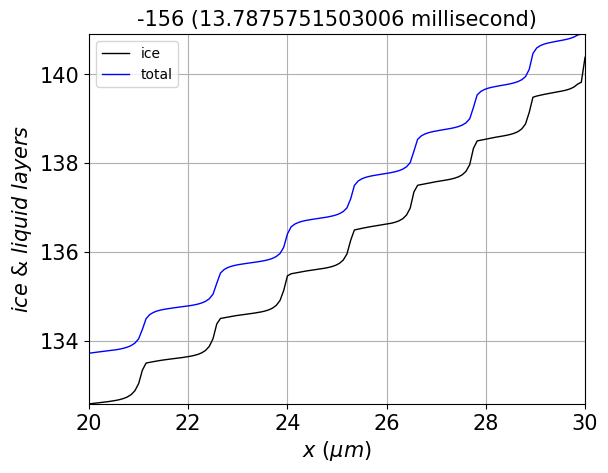

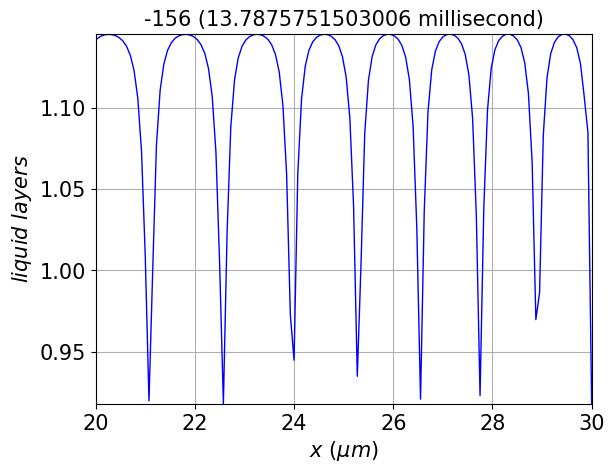

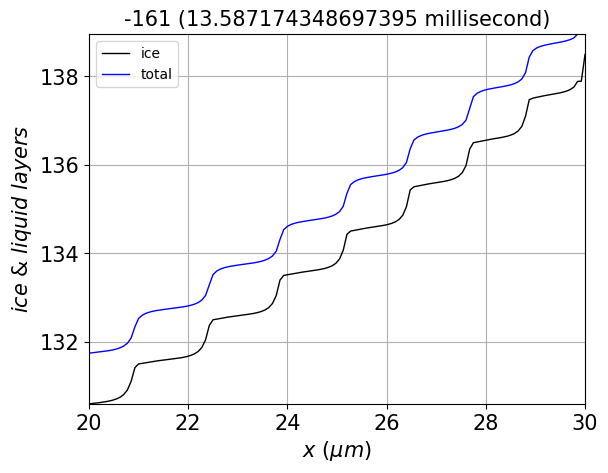

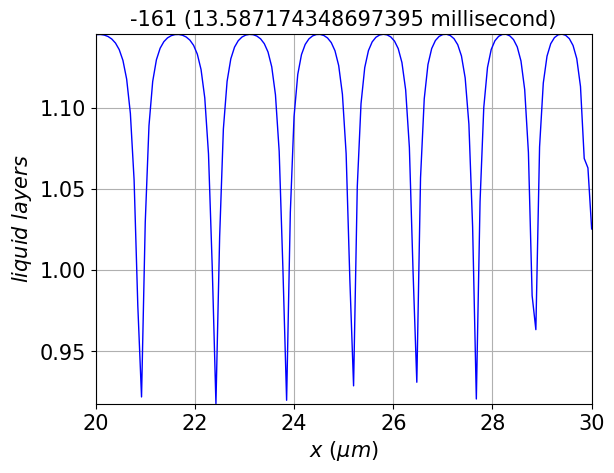

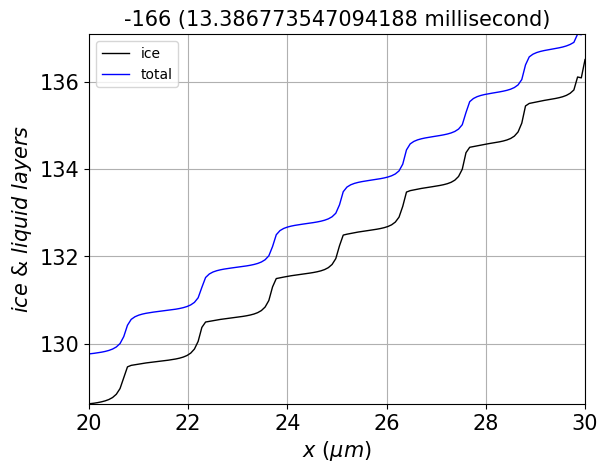

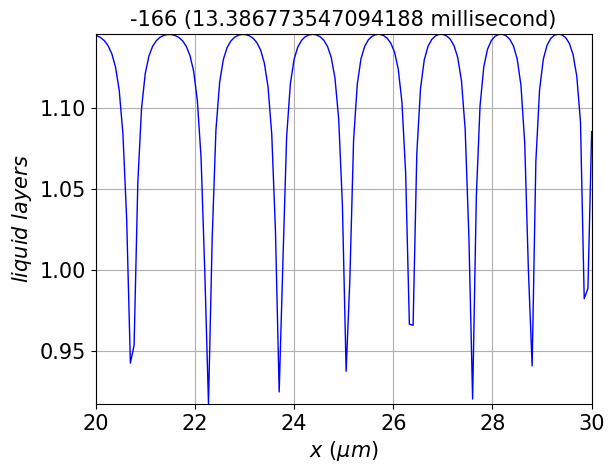

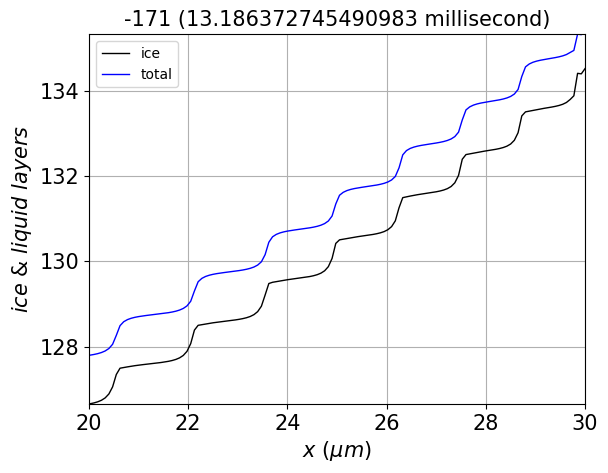

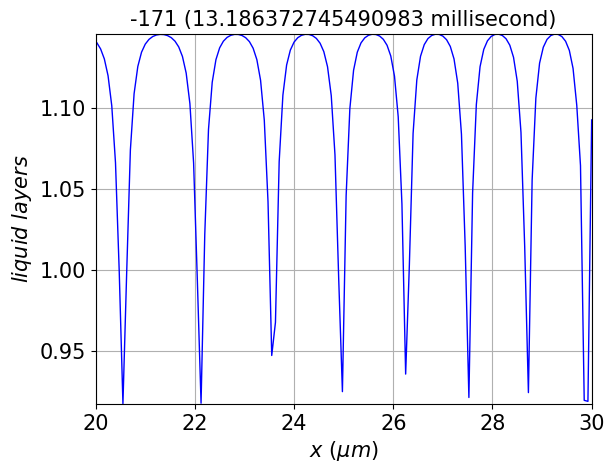

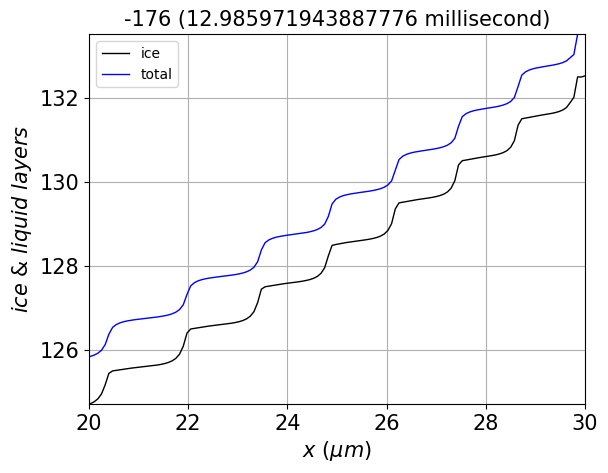

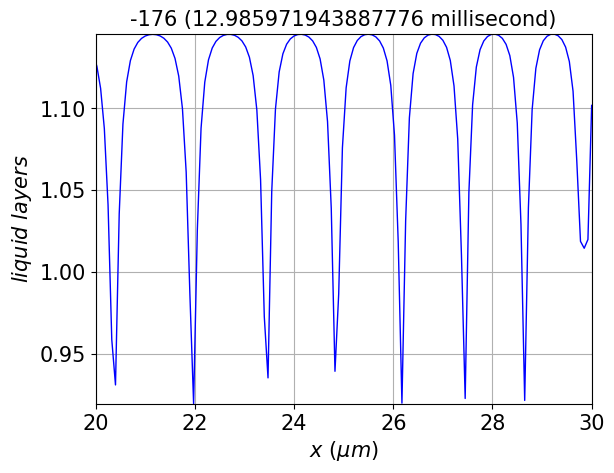

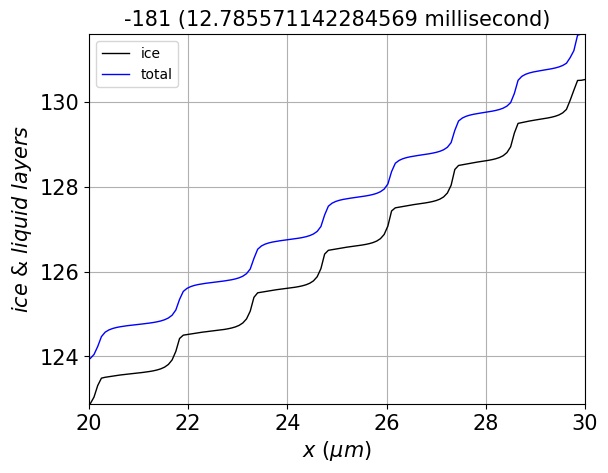

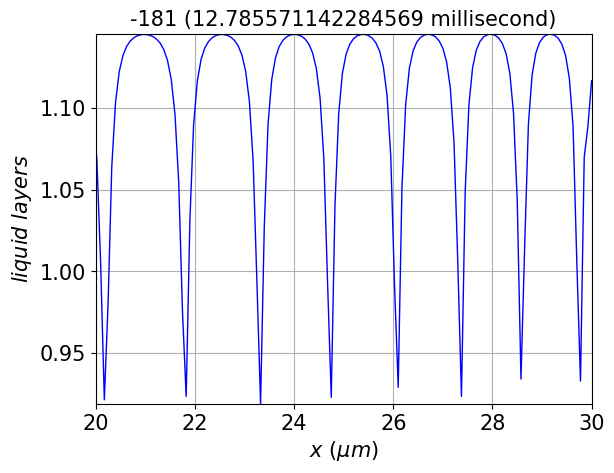

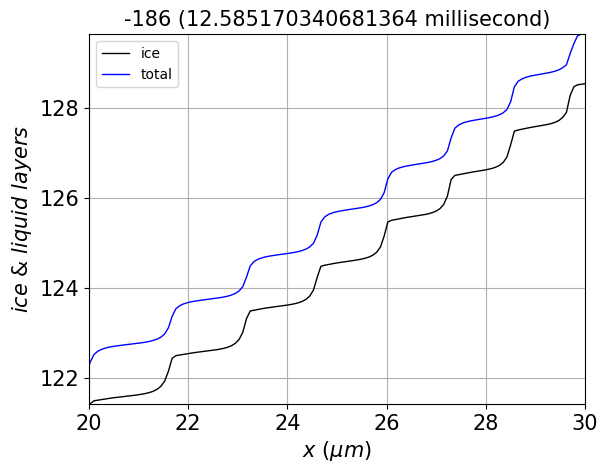

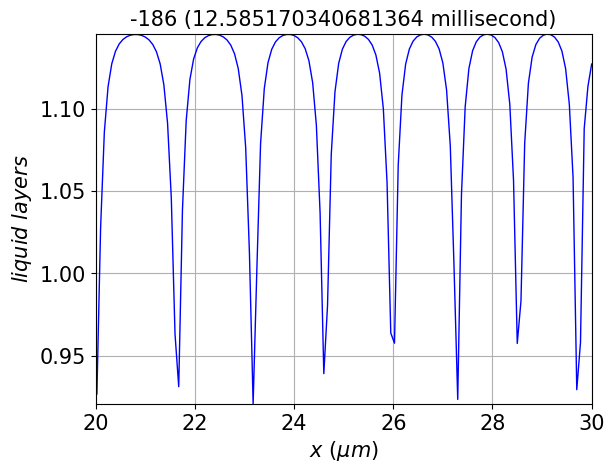

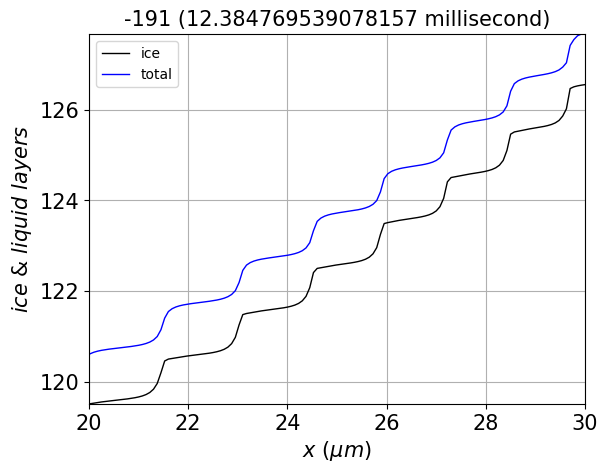

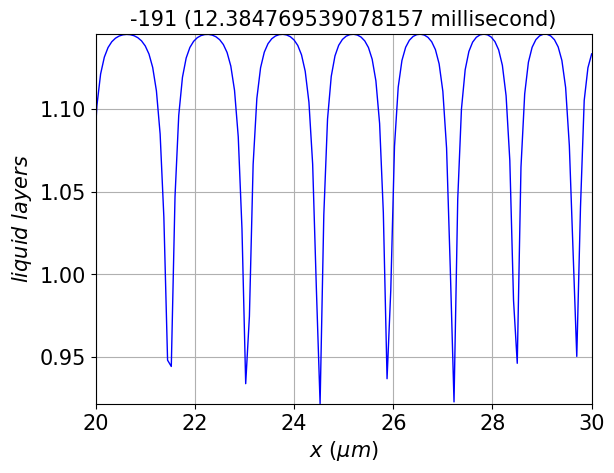

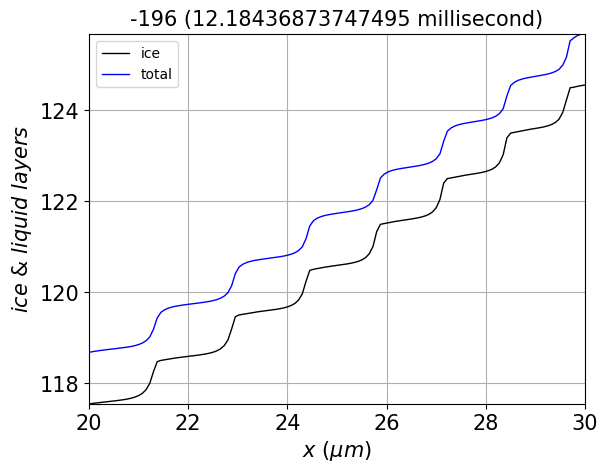

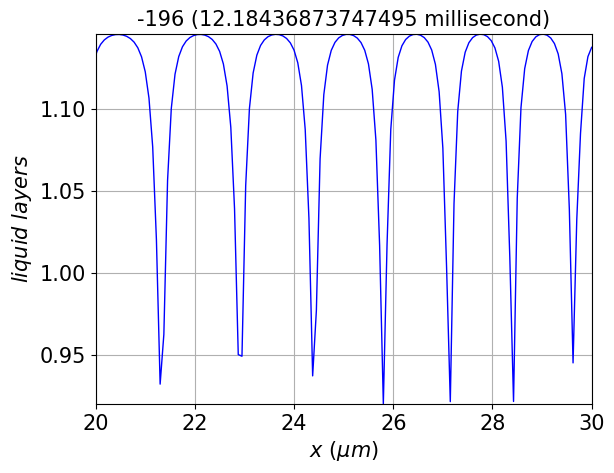

In [27]:
# Check out the last few times
for itime in range(-1,-200,-5):
    title_params = str(itime)+' ('+str(tkeep_1Darr[itime].to('millisecond'))+')'
    g_ice_QLC = QLC.report_1d_growth_results(\
        x_QLC,tkeep_1Darr,NQLLkeep_1D,Ntotkeep_1D,Nicekeep_1D,nmpermonolayer, \
        graphics=True,tgraphics=False,title_params=title_params,itime=itime, \
        xlim=[20,30])

In [28]:
# # See what we can learn about the last state
# scalar_params = np.array([Nbar, Nstar, sigma0, nu_kin_mlyperus.magnitude, Doverdeltax2.magnitude, tau_eq.magnitude])
# nx = len(Ntotkeep_1D)
# ylast = np.array([NQLLkeep_1D,Ntotkeep_1D])
# ylast = np.reshape(ylast,2*nx)
